# Post-stack, time domain Kirchhoff migration

In this eigth lab of the ErSE 210 - Seismology course, we will learn how to code a simple post-stack, time domain Kirchhoff demigration/migration engine.

Let's start by recalling the equation that can be used to model the propagation of waves from a scatterer at location $(x_s, t_0)$ in the subsurface to co-located sources and receivers at location $(x, t_0=0)$ (i.e., at the surface) under the assumption of laterally homogenous Earth with root-mean-square velocity $v_{rms}(t_0)$:    
$$
t_{kirch}(x_s, t_0, x) = \sqrt{t_0^2 + 4\frac{h^2}{v_{rms}^2}}
$$

where $t_0$ is the zero-offset traveltime, $h=x_s-x$ is the horizontal distance between the subsurface point of interest and the source/receiver.

**Kirchoff migration** refers to the process of taking the data $d(x_s, t)$ and transforming it into an image of the subsurface $i(x, t_0)$ (also called *reflectivity*), which is accomplished by summing all values along the traveltime curve $t_{kirch}(x_s, t_0, x) \; \forall x_s$:

$$
i(x, t_0) = \int \int d(x_s, t_{kirch}(x_s, t_0, x)) d x_s d t_0
$$

**Kirchoff demigration** is the opposite process, which entails modelling the data $d(x_s, t)$ from an image of the subsurface $i(x, t_0)$, which is accomplished by spreading the values of the image along the traveltime curve $t_{kirch}(x_s, t_0, x) \; \forall x$:

$$
d(x, t_{kirch}(x_s, t_0, x)) = \int \int i(x, t_0) d x d t_0
$$

Note that in practical applications, when modelling the data, the output of the above equation is usually convolved with a wavelet. As such, in order for the Kirchoff demigration/migration operator to be consisent, convolution with a time-flipped wavelet is also applied during migration.

The notebook is organized as follow:

- Create a synthetic post-stack dataset
- Perform migration

In [ ]:
# Install non-default Python packages (run once)
%pip install numpy matplotlib scipy pylops

> In the cell below, provide the full path to timemig.py file

In [2]:
import sys
sys.path.append("/full/path/to/parent/of/timemig.py")

In [3]:
%load_ext autoreload

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr

from pylops.utils.wavelets import *
from pylops.utils import dottest

from timemig import TimeKirchhoff

Let's start by creating a simple subsurface model composed of 3 scatterers. We also choose the root-mean-square velocity $v_{rms}(t_0)$ to be linearly increasing with two-way traveltime

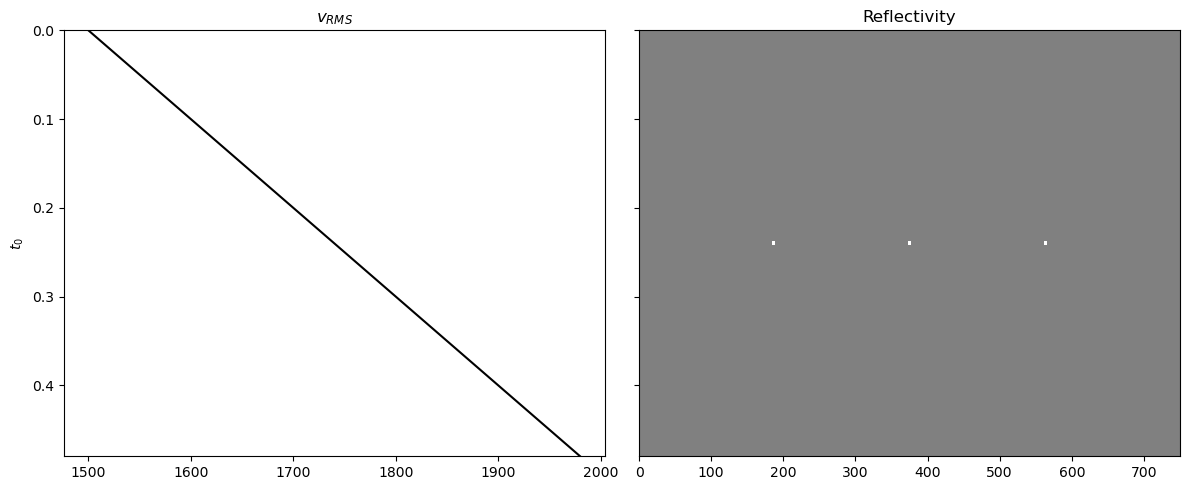

In [4]:
# Axes
nx, nt0 = 151, 121
dx, dt0 = 5, 0.004

x, t0 = np.arange(nx) * dx, np.arange(nt0) * dt0

# Velocity and reflectivity models
v0, kv = 1500, 1e3
vrms1d = t0 * kv + v0
vrms = np.repeat(vrms1d[:, None], nx, axis=1).T

refl = np.zeros((nx, nt0))
refl[nx//2, nt0//2] = 1
refl[nx//4, nt0//2] = 1
refl[3*nx//4, nt0//2] = 1

# Wavelet
wav, _, wavc = ricker(t0[:21], f0=30)

# Visualize 
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
axs[0].plot(vrms1d, t0, 'k')
axs[0].set_title(r'$v_{RMS}$')
axs[0].set_ylabel(r'$t_0$')
axs[1].imshow(refl.T, cmap='gray', extent=(x[0], x[-1], t0[-1], t0[0]), vmin=-.5, vmax=.5)
axs[1].set_title('Reflectivity')
axs[1].axis('tight')
plt.tight_layout()

We create now the ``TimeKirchhoff`` operator that performs the demigration/migration operations discussed above. For convenience, this is implemented as a [PyLops](http://github.com/pylops/pylops) operator.

Whilst the operator is created, all of the traveltimes are pre-computed. In practice, since we have a simple analytical expression the traveltimes could be computed on-the-fly when performing demigration/migration.

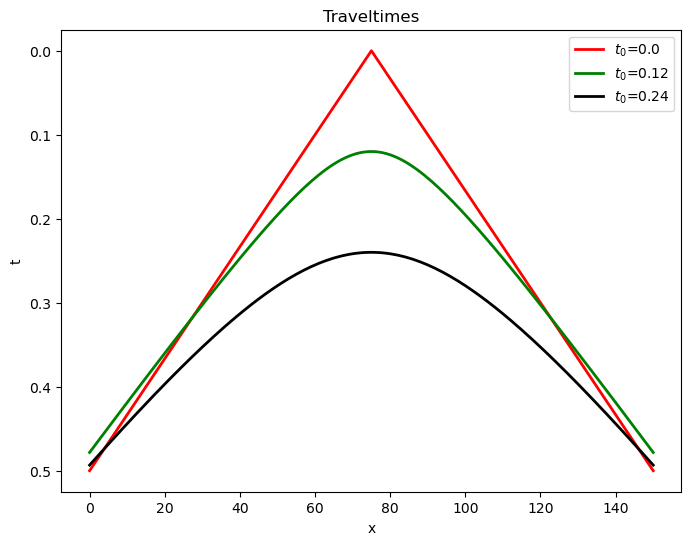

In [5]:
Top = TimeKirchhoff(t0, x, vrms, wav, wavc, engine="numba")

# Display some traveltimes
plt.figure(figsize=(8, 6))
plt.plot(Top.trav[:, nx//2, 0], 'r', lw=2, label=fr'$t_0$={t0[0]}')
plt.plot(Top.trav[:, nx//2, nt0//4], 'g', lw=2, label=fr'$t_0$={t0[nt0//4]}')
plt.plot(Top.trav[:, nx//2, nt0//2], 'k', lw=2, label=fr'$t_0$={t0[nt0//2]}')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Traveltimes');

Let's now model the data and migrate it with the same engine.

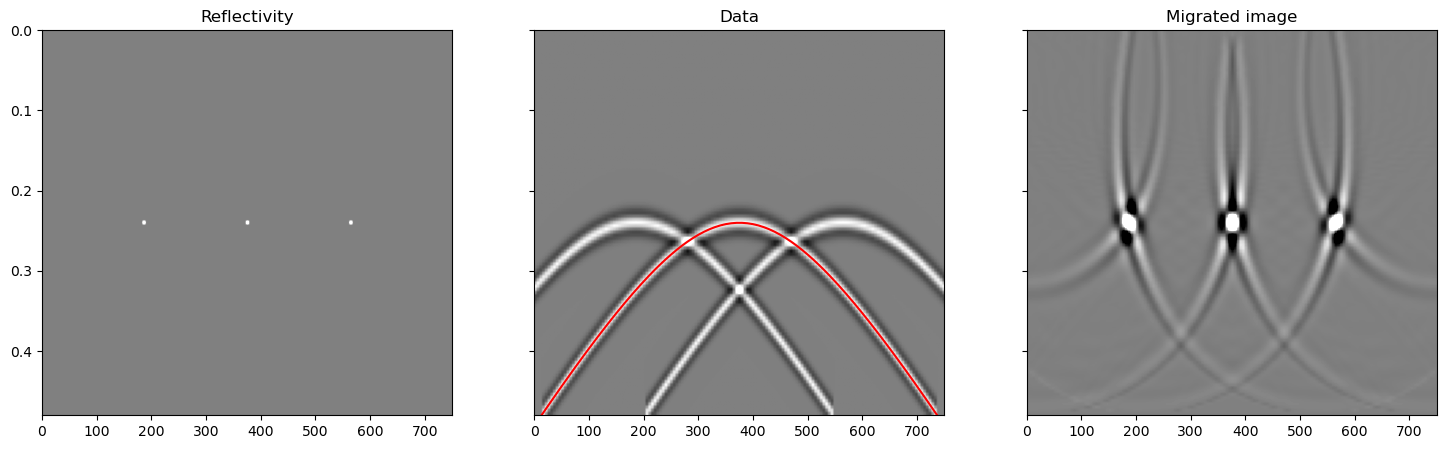

In [6]:
# Model data (demigration)
data = Top @ refl

# Image data (migration)
reflmig = Top.H @ data

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 5))
axs[0].imshow(refl.T, cmap='gray', extent=(x[0], x[-1], t0[-1], t0[0]), vmin=-.5, vmax=.5)
axs[0].axis('tight')
axs[0].set_title('Reflectivity')

axs[1].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].plot(x, Top.trav[:, nx//2, nt0//2], 'r')
axs[1].axis('tight')
axs[1].set_title('Data')

axs[2].imshow(reflmig.T, cmap='gray', vmin=-5e1, vmax=5e1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axis('tight')
axs[2].set_title('Migrated image')

axs[2].set_ylim(t0[-1], t0[0]);

We see that the image present some artefact, so-called migration swings. 

We can do better by either adding more sources/receivers or by solving the migration problem as an inversion process. Let's see how to do this using PyLops.

## Least-squares migration

In [ ]:
# Migration by inversion (aka least-squares migration)
reflinv = lsqr(Top, data.ravel(), iter_lim=10, damp=1e-2, show=True)[0]
reflinv = reflinv.reshape(nx, nt0)
datainv = Top @ reflinv

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 5))
axs[0].imshow(reflinv.T, cmap='gray', extent=(x[0], x[-1], t0[-1], t0[0]), vmin=-.5, vmax=.5)
axs[0].axis('tight')
axs[0].set_title('Inverted reflectivity')

axs[1].imshow(datainv.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axis('tight')
axs[1].set_title('Modelled Data')

axs[2].imshow(data.T-datainv.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axis('tight')
axs[2].set_title('Data error')

axs[2].set_ylim(t0[-1], t0[0]);

Re-run the least-squares migration three times by increasing the number of iterations and compare the output.

Which method gives sharper reflectors?

Which method better recovers amplitudes?

How does the migrated image looks like if the reflectivity was a horizontal layer at nt0//2, instead of three point scatterres?